### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two or three people.
* The deadline is Friday, 01.06.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import numpy as np

from torch.autograd import Variable

## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [3]:
def binarize(X):
        binarized = X > 128
        return binarized.astype(float)

In [4]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

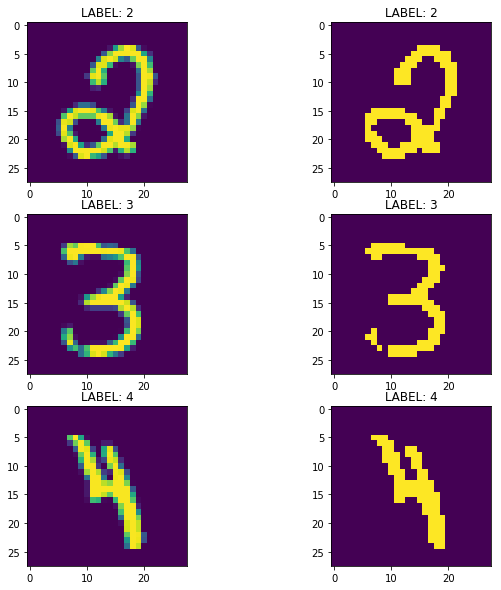

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

#samples from digits 2,3 and 4
itemindex_two = np.array(np.where(train_labels==2))
itemindex_three = np.array(np.where(train_labels==3))
itemindex_four = np.array(np.where(train_labels==4))

samples_two = numpy.random.choice(range(itemindex_two.shape[1]),1)
samples_three = numpy.random.choice(range(itemindex_three.shape[1]),1)
samples_four = numpy.random.choice(range(itemindex_four.shape[1]),1)

# plotting
fig = plt.figure()

p1 = plt.subplot(3, 2, 1)
plt.title("LABEL: 2")
plt.imshow(train_data[itemindex_two[0,samples_two[0]]].reshape(28,28))
p2 = plt.subplot(3, 2, 2)
plt.title("LABEL: 2")
plt.imshow(bin_train_data[itemindex_two[0,samples_two[0]]].reshape(28,28))
p3 = plt.subplot(3, 2, 3)
plt.title("LABEL: 3")
plt.imshow(train_data[itemindex_three[0,samples_three[0]]].reshape(28,28))
p4 = plt.subplot(3, 2, 4)
plt.title("LABEL: 3")
plt.imshow(bin_train_data[itemindex_three[0,samples_three[0]]].reshape(28,28))
p5 = plt.subplot(3, 2, 5)
plt.title("LABEL: 4")
plt.imshow(train_data[itemindex_four[0,samples_four[0]]].reshape(28,28))
p6 = plt.subplot(3, 2, 6)
plt.title("LABEL: 4")
plt.imshow(bin_train_data[itemindex_four[0,samples_four[0]]].reshape(28,28))
plt.show()

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [6]:
from scipy.misc import logsumexp

def E_step(X, mu, pi):
    '''
    X: NxD
    mu: KxD
    pi: K
    gamma: NxK
    '''
    lls = []
    gamma_num = np.log(pi) + np.dot(X,np.transpose(np.log(mu+1e-10))) + np.dot((1.-X),np.transpose(np.log(1.-mu + 1e-10)))
    norm = logsumexp(gamma_num, axis=1, keepdims=True)
    gamma = np.exp(gamma_num - norm)

    return gamma,np.mean(norm)

In [7]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test,norm_mean = E_step(X_test, mu_test, pi_test)

assert gamma_test.shape == (n_test, K_test)


/home/akashrajkn/.conda/envs/jalebi/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  if sys.path[0] == '':


In [8]:
def M_step(X, gamma):
    pi = gamma.sum(axis=0)/len(gamma)
    mu_unorm = np.dot(np.transpose(gamma),X)
    mu = mu_unorm / gamma.sum(axis=0,keepdims=True).T

    return mu, pi

In [9]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [10]:
def EM(X, K, max_iter, true_labels = False):
    
    N = X.shape[0]

    if not true_labels:
        # Initializing gamma
        gamma = np.eye(K)[np.random.choice(K, N)] #NxK
    else:
        gamma_list = [[1,0,0]] * 5958 + [[0,1,0]] * 6131 + [[0,0,1]] * 5842
        gamma = np.array(gamma_list)
        print(gamma.shape)

    ll = []
    count = 0
    
    #stopping criteria
    stop_c = 1e-5

    while count < max_iter: 
        count+=1

        #M-step
        mu, pi = M_step(X, gamma)
        # E-step
        gamma,norm_mean = E_step(X, mu, pi)

        ll.append(norm_mean)
        print("Iteration {}; Average log-likelihood: {}".format(count,norm_mean))

        # covergence check
        if count>1:
            if np.abs(ll[count-1] - ll[count-2]) < stop_c*np.abs(ll[count-1]):
                print("converged, as stopping criterion reached")
                break
            
    return mu, pi, gamma

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

In [11]:
# dataset
three_digits_labels = np.array(np.where(train_labels==2)).tolist() + np.array(np.where(train_labels==3)).tolist() +  np.array(np.where(train_labels==4)).tolist()
flat = [item for sublist in three_digits_labels for item in sublist]
idx = np.array(flat)
data = bin_train_data[idx]
data.shape

(17931, 784)

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

/home/akashrajkn/.conda/envs/jalebi/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  if sys.path[0] == '':


Iteration 1; Average log-likelihood: -207.16340321199
Iteration 2; Average log-likelihood: -197.26906616326204
Iteration 3; Average log-likelihood: -191.30247930141576
Iteration 4; Average log-likelihood: -189.38530018401318
Iteration 5; Average log-likelihood: -188.2167386650622
Iteration 6; Average log-likelihood: -187.40564613019927
Iteration 7; Average log-likelihood: -186.5795864256247
Iteration 8; Average log-likelihood: -185.60673170362307
Iteration 9; Average log-likelihood: -184.82643229515972
Iteration 10; Average log-likelihood: -184.42090479235972
Iteration 11; Average log-likelihood: -184.2698157026469
Iteration 12; Average log-likelihood: -184.20454292327318
Iteration 13; Average log-likelihood: -184.17366041026585
Iteration 14; Average log-likelihood: -184.15735858824902
Iteration 15; Average log-likelihood: -184.14957272207704
Iteration 16; Average log-likelihood: -184.14617830157005
Iteration 17; Average log-likelihood: -184.14455164212612
converged, as stopping criter

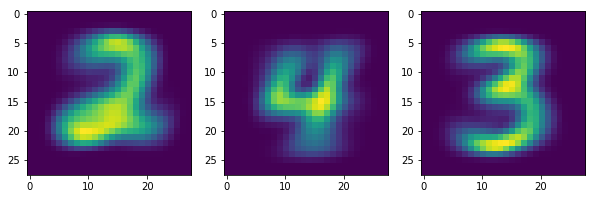

Mixing coefficients: [0.31584641 0.34752717 0.33662642]
True Mixing coefficients: [0.33227372 0.34192181 0.32580447]


In [12]:
def plot_latent(mu,K):
    fig = plt.figure()
    for i in range(K):
        plt.subplot(1,K,i+1)
        plt.imshow(mu[i,:].reshape(28,28))
    plt.show()
    
mu,pi,gamma = EM(data,3, 200)
plot_latent(mu,3)

print("Mixing coefficients:",pi)

true_pi = np.array([np.array(np.where(train_labels==2)).shape[1],np.array(np.where(train_labels==3)).shape[1],np.array(np.where(train_labels==4)).shape[1]])
print("True Mixing coefficients:",true_pi/np.sum(true_pi) )


$\textbf{Answer:}$ Yes, clearly as above below the elements in the latent space encode the three digits 3,2 and 4. Also, the learned mixing coefficients are close to the true mixing coefficients.

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

----------------------EM with K=2----------------------
Iteration 1; Average log-likelihood: -207.27698575365093
Iteration 2; Average log-likelihood: -203.33565130349794


/home/akashrajkn/.conda/envs/jalebi/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  if sys.path[0] == '':


Iteration 3; Average log-likelihood: -195.91784281519242
Iteration 4; Average log-likelihood: -194.51265052401178
Iteration 5; Average log-likelihood: -194.27514878631607
Iteration 6; Average log-likelihood: -194.24105505092078
Iteration 7; Average log-likelihood: -194.22239136621792
Iteration 8; Average log-likelihood: -194.20126045130849
Iteration 9; Average log-likelihood: -194.16758729136154
Iteration 10; Average log-likelihood: -194.1245023619008
Iteration 11; Average log-likelihood: -194.06263078904323
Iteration 12; Average log-likelihood: -193.99399273844705
Iteration 13; Average log-likelihood: -193.93221215677622
Iteration 14; Average log-likelihood: -193.8848388902823
Iteration 15; Average log-likelihood: -193.85653928860805
Iteration 16; Average log-likelihood: -193.8442268908328
Iteration 17; Average log-likelihood: -193.83939552408023
Iteration 18; Average log-likelihood: -193.8377429598998
converged, as stopping criterion reached


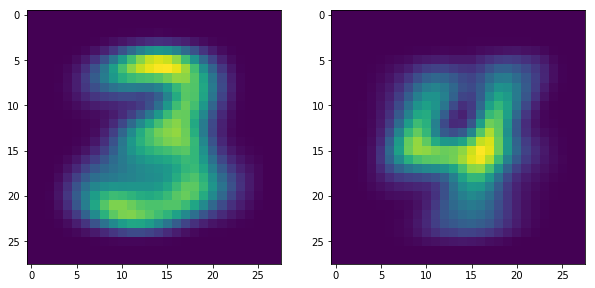

----------------------EM with K=5----------------------
Iteration 1; Average log-likelihood: -207.02725986679707
Iteration 2; Average log-likelihood: -193.39797981270823
Iteration 3; Average log-likelihood: -183.0166778315637
Iteration 4; Average log-likelihood: -181.55552833323765
Iteration 5; Average log-likelihood: -180.6238887986848
Iteration 6; Average log-likelihood: -179.7147955798779
Iteration 7; Average log-likelihood: -179.12560216687194
Iteration 8; Average log-likelihood: -178.72056440342524
Iteration 9; Average log-likelihood: -178.21601655098118
Iteration 10; Average log-likelihood: -177.5308522043902
Iteration 11; Average log-likelihood: -176.95768694584416
Iteration 12; Average log-likelihood: -176.5972956026139
Iteration 13; Average log-likelihood: -176.31453899033704
Iteration 14; Average log-likelihood: -176.1041941397514
Iteration 15; Average log-likelihood: -175.9827502967767
Iteration 16; Average log-likelihood: -175.92472281678263
Iteration 17; Average log-likeli

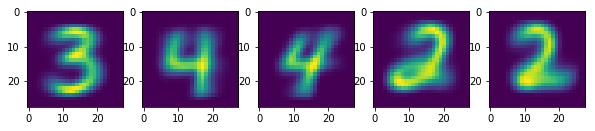

In [13]:
print("----------------------EM with K=2----------------------")
mu1,pi,gamma = EM(data,2, 200)
plot_latent(mu1,2)

print("----------------------EM with K=5----------------------")
mu2,pi,gamma = EM(data,5, 200)
plot_latent(mu2,5)

$\textbf{Answer:}$ Above we are plotting the latent spaces with K=2 and K=5 respectively.

-  Interestingly, a smaller latent space (K=2) produces plots of the spaces mostly looking like the numbers 3 and 4 with number 2 being absent. However, the plot of the 3 seems to look a bit like a mix of the letters 2 and 3. It is quite interesting that the number 2 got mixed up more with the latent space of the 3 which makes intuitive sense as the number look more alike.

- For a larger latent space (K=5) we also observe quite interesting results. Especially, there are now two representations of the number 2 and two of the number 4. These extra representations show distinct ways of writing the numbers. For example the number 2 is shown with a "loopy" tail and a "flat" tail.

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

/home/akashrajkn/.conda/envs/jalebi/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  if sys.path[0] == '':


Iteration 1; Average log-likelihood: -207.15680996316672
Iteration 2; Average log-likelihood: -194.72222969372953
Iteration 3; Average log-likelihood: -184.73096512695864
Iteration 4; Average log-likelihood: -184.211458287987
Iteration 5; Average log-likelihood: -184.16140863993883
Iteration 6; Average log-likelihood: -184.15087559480156
Iteration 7; Average log-likelihood: -184.14689601086036
Iteration 8; Average log-likelihood: -184.14441322015793
Iteration 9; Average log-likelihood: -184.14331329953882
converged, as stopping criterion reached


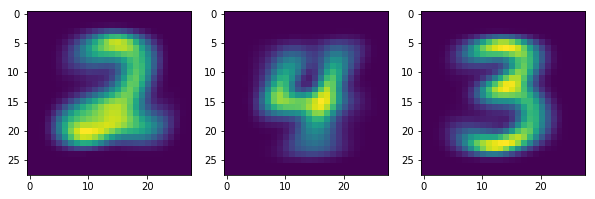

In [14]:
mu,pi,gamma = EM(data,3, 200)
# identify which component in the latent space got assigned to which number.
plot_latent(mu,3)


Falsely classified as 4


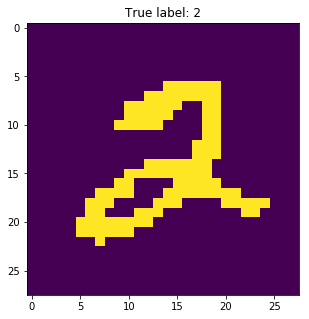

Falsely classified as 4


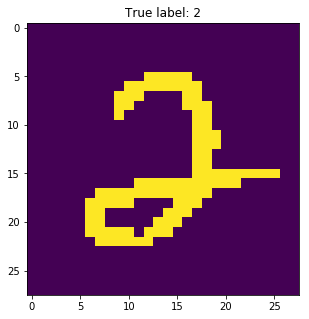

Falsely classified as 2


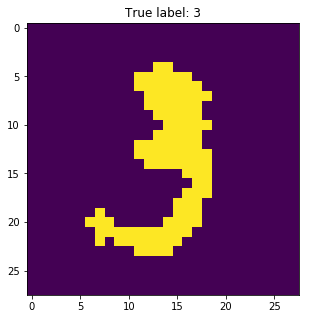

Falsely classified as 2


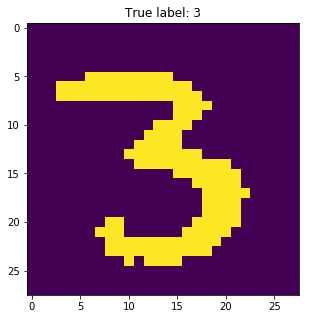

Falsely classified as 3


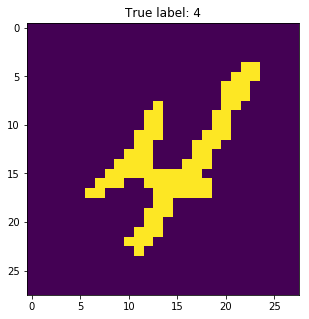

Falsely classified as 3


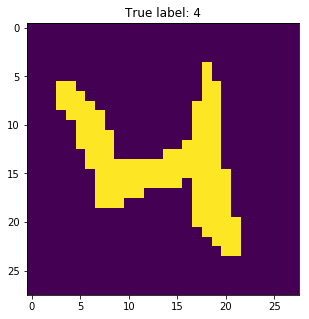

In [15]:
plt.rcParams['figure.figsize'] = [5, 5]

# datapoints 1-5958 : 2, datapoints 5959-12089 : 3, datapoints 12089-17931: 4
correct = 0
count2 = 0
count3 = 0
count4 = 0

for j in range(gamma.shape[0]):
    
    if j <= 5958:
        if np.argmax(gamma[j]) == 2:    # change this for every new model
            correct+=1
        elif count2 < 2:
            count2+=1
            # change this for every new model
            if np.argmax(gamma[j]) == 0:
                label1 = 4
            elif np.argmax(gamma[j]) == 1:
                label1 = 3
            elif np.argmax(gamma[j]) == 2:
                label1 = 2
            print("Falsely classified as {}".format(label1))
            im2 = plt.imshow(data[j,:].reshape(28,28))
            plt.title("True label: 2")
                  
    elif j >= 5958 and j <= 12089:
        if np.argmax(gamma[j]) == 1:        # change this for every new model
            correct+=1
        elif count3 < 2:
            count3+=1
            # change this for every new model
            if np.argmax(gamma[j]) == 0:
                label2 = 4
            elif np.argmax(gamma[j]) == 1:
                label2 = 3
            elif np.argmax(gamma[j]) == 2:
                label2 = 2
                  
            print("Falsely classified as {}".format(label2))
            im2 = plt.imshow(data[j,:].reshape(28,28))
            plt.title("True label: 3")
                  
    elif j >= 12089:
        if np.argmax(gamma[j]) == 0:      # change this for every new model
            correct+=1
        elif count4 < 2:
            count4+=1
            # change this for every new model
            if np.argmax(gamma[j]) == 0:    
                label3 = 4
            elif np.argmax(gamma[j]) == 1:
                label3 = 3
            elif np.argmax(gamma[j]) == 2:
                label3 = 2
            print("Falsely classified as {}".format(label3))
            im2 = plt.imshow(data[j,:].reshape(28,28))
            plt.title("True label: 4")
    plt.show()

$\textbf{Answer:}$ It is hard to tell why exactly specific images are missclassified. However, some of the above plotted examples are w.r.t. their label. Especially the 3s and the 4s that are plotted above show some rotation and other variations that let them be too different from the learned latent space.

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

In [16]:
print("------------ iniatialized randomly values --------------")
mu,pi,gamma = EM(data,3, 200)

print("------------ iniatialized with true values --------------")
mu,pi,gamma = EM(data,3, 200, True)


------------ iniatialized randomly values --------------
Iteration 1; Average log-likelihood: -207.23937367263784
Iteration 2; Average log-likelihood: -198.4072993768564


/home/akashrajkn/.conda/envs/jalebi/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  if sys.path[0] == '':


Iteration 3; Average log-likelihood: -187.36576319532185
Iteration 4; Average log-likelihood: -185.43907295076642
Iteration 5; Average log-likelihood: -184.61147894903783
Iteration 6; Average log-likelihood: -184.34509019785997
Iteration 7; Average log-likelihood: -184.24270197289033
Iteration 8; Average log-likelihood: -184.18725263881117
Iteration 9; Average log-likelihood: -184.16363640408707
Iteration 10; Average log-likelihood: -184.15441017398257
Iteration 11; Average log-likelihood: -184.1490431555818
Iteration 12; Average log-likelihood: -184.1448163504205
Iteration 13; Average log-likelihood: -184.14074822551117
Iteration 14; Average log-likelihood: -184.14047295980768
converged, as stopping criterion reached
------------ iniatialized with true values --------------
(17931, 3)
Iteration 1; Average log-likelihood: -184.5944971066356
Iteration 2; Average log-likelihood: -184.23561164635166
Iteration 3; Average log-likelihood: -184.1731827511606
Iteration 4; Average log-likelihoo

$\textbf{Answer:}$ Clearly, convergence is much faster when images are assigned their true labels. Also the average log likelihood starts off at -184.59 which is already as low as the final average log likelihood in the randomly assigned version.

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [17]:
def log_bernoulli_loss(x_hat, x):
    neg_loss = torch.mul(x, torch.log(x_hat)) + torch.mul(1 - x, torch.log(1 - x_hat))
    return -neg_loss.sum()

In [18]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

\begin{align*}
\mathcal{KL}(q || p) &= -\frac{1}{2} \sum_{i=1}^N \left[ 1 + \text{log}\sigma_i^2 - \mu_i^2 - \sigma_i^2 \right]
\end{align*}

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [19]:
def KL_loss(mu, logvar):

    loss = -0.5 * torch.sum(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
    return loss

In [20]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [21]:
def loss_function(x_hat, x, mu, logvar):
    
    entropy_term = log_bernoulli_loss(x_hat, x)
    kl_term = KL_loss(mu, logvar)
    
    return entropy_term + kl_term

In [22]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [23]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [24]:
def encode(self, x):

    # z - latent variable
    z = F.sigmoid(self.fc1(x))

    mu = self.fc21(z)
    logvar = torch.exp(torch.mul(self.fc22(z), 0.5))

    return mu, logvar

In [25]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [26]:
def reparameterize(self, mu, logvar):

    epsilon = Variable(logvar.data.new(logvar.size()).normal_())
    z = mu + epsilon.mul(logvar)

    return z

In [27]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [28]:
def decode(self, z):

    x_hat = F.sigmoid(self.fc4(F.sigmoid(self.fc3(z))))

    return x_hat

In [29]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [30]:
def forward(self, x):
    x = x.view(-1, 784)
    
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)

    return x_hat, mu, logvar

In [31]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [32]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [33]:
# Hyperparameters
fc1_dims = (784, 500)
fc21_dims = (500, 25)
fc22_dims = (500, 25)
fc3_dims = (25, 500)
fc4_dims = (500, 784)
lr = 0.001
batch_size = 100
epochs = 10

In [34]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [35]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 563.932434
Train Epoch: 1 [10000/60000 (17%)]	Loss: 191.523209
Train Epoch: 1 [20000/60000 (33%)]	Loss: 156.069229
Train Epoch: 1 [30000/60000 (50%)]	Loss: 144.669449
Train Epoch: 1 [40000/60000 (67%)]	Loss: 129.826035
Train Epoch: 1 [50000/60000 (83%)]	Loss: 125.098976
====> Epoch: 1 Average loss: 156.7780
Train Epoch: 2 [0/60000 (0%)]	Loss: 124.807274
Train Epoch: 2 [10000/60000 (17%)]	Loss: 113.286858
Train Epoch: 2 [20000/60000 (33%)]	Loss: 107.706970
Train Epoch: 2 [30000/60000 (50%)]	Loss: 97.842621
Train Epoch: 2 [40000/60000 (67%)]	Loss: 106.511894
Train Epoch: 2 [50000/60000 (83%)]	Loss: 97.414413
====> Epoch: 2 Average loss: 107.7859
Train Epoch: 3 [0/60000 (0%)]	Loss: 98.163994
Train Epoch: 3 [10000/60000 (17%)]	Loss: 96.504044
Train Epoch: 3 [20000/60000 (33%)]	Loss: 97.964241
Train Epoch: 3 [30000/60000 (50%)]	Loss: 92.451843
Train Epoch: 3 [40000/60000 (67%)]	Loss: 93.253601
Train Epoch: 3 [50000/60000 (83%)]	Loss: 91.248116
====> Epoch

Run the box below to check if the model you trained above is able to correctly reconstruct images.

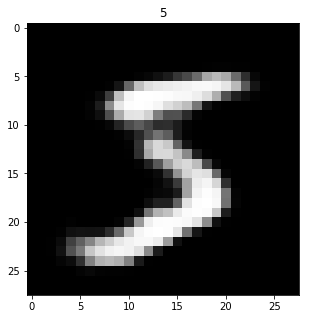

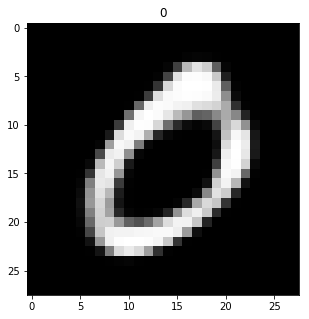

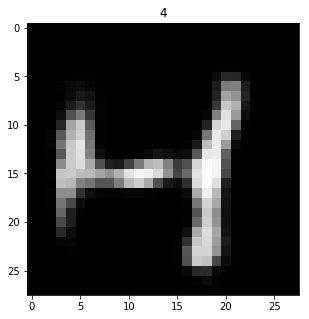

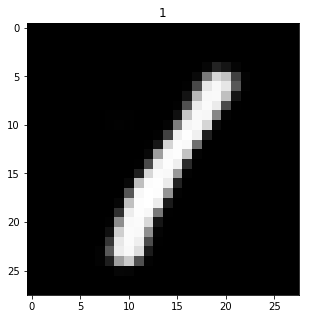

In [36]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [37]:
def plot_function(n, vae_model):
    '''
    Visualize latent space.
    Resource: https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df
    '''
    plt.rcParams['figure.figsize'] = [n, n]
    _, ax = plt.subplots(n, n)
    x = np.linspace(-3, 3, n)
    y = np.linspace(-3, 3, n)

    for xi, i in enumerate(x):
        for yi, j in enumerate(y):
            z_sample = torch.FloatTensor([i, j]).unsqueeze(0)
            x_sample = vae_model.decode(z_sample).data.numpy()
            ax[xi, yi].imshow(x_sample.reshape(28, -1))
            ax[xi, yi].axis('off')

    plt.show()
    plt.rcParams['figure.figsize'] = [6, 6]

Train Epoch: 1 [0/60000 (0%)]	Loss: 555.964355
Train Epoch: 1 [10000/60000 (17%)]	Loss: 181.269958
Train Epoch: 1 [20000/60000 (33%)]	Loss: 181.473190
Train Epoch: 1 [30000/60000 (50%)]	Loss: 181.903275
Train Epoch: 1 [40000/60000 (67%)]	Loss: 169.655823
Train Epoch: 1 [50000/60000 (83%)]	Loss: 177.963806
====> Epoch: 1 Average loss: 185.0241
Train Epoch: 2 [0/60000 (0%)]	Loss: 178.981812
Train Epoch: 2 [10000/60000 (17%)]	Loss: 166.836197
Train Epoch: 2 [20000/60000 (33%)]	Loss: 178.838394
Train Epoch: 2 [30000/60000 (50%)]	Loss: 175.922363
Train Epoch: 2 [40000/60000 (67%)]	Loss: 170.289474
Train Epoch: 2 [50000/60000 (83%)]	Loss: 170.039276
====> Epoch: 2 Average loss: 174.0024
Train Epoch: 3 [0/60000 (0%)]	Loss: 173.630722
Train Epoch: 3 [10000/60000 (17%)]	Loss: 176.479568
Train Epoch: 3 [20000/60000 (33%)]	Loss: 171.355896
Train Epoch: 3 [30000/60000 (50%)]	Loss: 164.345505
Train Epoch: 3 [40000/60000 (67%)]	Loss: 170.135483
Train Epoch: 3 [50000/60000 (83%)]	Loss: 155.216461
===

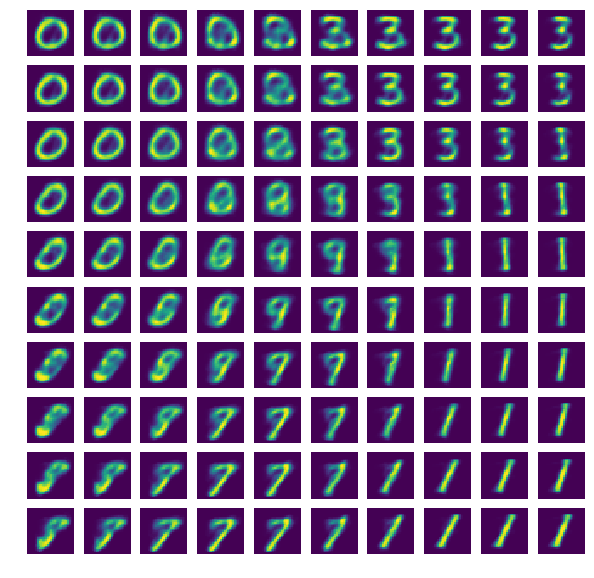

In [38]:
# Hyperparameters:
fc1_dims = (784, 500)
fc21_dims = (500, 2)
fc22_dims = (500, 2)
fc3_dims = (2, 500)
fc4_dims = (500, 784)

lr = 0.001
batch_size = 100
epochs = 5

vae2 = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)
optimizer = optim.Adam(vae2.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(epoch, train_loader, vae2, optimizer)
    
plot_function(10, vae2)

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


1. In the vanilla VAE, each latent variable, $z_n$ has a variational distribution, $q(z_n)$. As the number of observations and latent variables grow, the model becomes complex due to the the number of parameters involved. In amortized inference, we model $q(z|x, \theta)$, where $\theta$ is shared across all the observations. 

2. In this code, amortization is used in the encoder by generating mean and log variance (using reparameterization trick) from the input embeddings.

3. Amortization helps in solving a large number of optimization problems at once. As the number of observations and latent variables grow, we can still control the number of parameters to be optimized.